# Your Title Here

**Name(s)**: (your name(s) here)

**Website Link**: (your website link)

## Code

In [86]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

import plotly.express as px
import plotly.graph_objs as go

from IPython.display import display

import black

### Framing the Problem

In [ ]:
# TODO

"""
League of Legends Competitive Matches:

Predict if a team will win or lose a game.
Predict which role (top-lane, jungle, support, etc.) a player played given their post-game data.
Predict how long a game will take before it happens.
Predict which team will get the first Baron.
"""

### Cleaning

Code copied from our project 3. We as well are only interested in the player-related rows. Team-related rows have been dropped. 

In [4]:
# Load Dataset
league_fp = os.path.join('data', '2022_LoL_esports_match_data_from_OraclesElixir.csv')
league_raw = pd.read_csv(league_fp)

league_raw.dtypes

/Users/elim-mbp-01/.pyenv/versions/3.8.16/envs/dsc80_39/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3505: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


gameid               object
datacompleteness     object
url                  object
league               object
year                  int64
                     ...   
assistsat15         float64
deathsat15          float64
opp_killsat15       float64
opp_assistsat15     float64
opp_deathsat15      float64
Length: 123, dtype: object

In [5]:
# =======================
# CLEANING 
# =======================

league = league_raw.copy()

# =======================================================
# Some rows are marked with datacompleteness = "partial"/"ignore".
# According to Costin, this label just means that there's a NaN value in the row (excluding NaN's from team/player related columns)
# Will not ignore.
# league = league[league["datacompleteness"] == "complete"]
# =======================================================

# =======================================================
# Each 'gameid' corresponds to up to 12 rows – one for each of the 5 players on both teams and 2 containing summary data for the two teams (try to find out what distinguishes those rows). After selecting your line of inquiry, make sure to remove either the player rows or the team rows so as not to have issues later in your analysis.

# 24900 rows without a champion 
# (league_raw["champion"].isna()).sum()
# 149400 rows total. 12 rows per match. 149400 / 12 = 12450 matches. 
# 12450 * 2 = 24900 team related rows
# (149400 / 12) = 12450 matches. 12450 * 2 = 24900
# Filtering by whether there's a champion listed or not, should get only the player related rows
league = league[league["champion"].notna()]

# Also drop the team related columns. Every single value in those columns should be null for the player related rows
team_columns_mask = league.isnull().sum(axis=0) == league.shape[0]
league = league.drop(columns=league.columns[team_columns_mask])
print(f"{team_columns_mask.sum()} team-related columns removed")
# =======================================================

# =======================================================
# NaN values for players are represented as "unkown player"
# Mark these as NaN
league["playername"] = league["playername"].apply(lambda val: np.nan if val == "unknown player" else val)
# =======================================================


# =======================================================
# Many columns should be of type bool but are not.
# Checks each column to see if the set of unique values is {0, 1}
# If so, converts the column to bool
columns_to_bool = []
for column in league.columns:
    value_counts = league[column].value_counts()
    if set(value_counts.index) == {0, 1}:
        columns_to_bool.append(column)
        league[column] = league[column].astype(bool)
print(f"CONVERTED {len(columns_to_bool)} COLUMNS TO BOOL")
# =======================================================

# =======================================================
league = league.convert_dtypes()
league.info()
# =======================================================

26 team-related columns removed
CONVERTED 6 COLUMNS TO BOOL
<class 'pandas.core.frame.DataFrame'>
Int64Index: 124500 entries, 0 to 149397
Data columns (total 97 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   gameid                    124500 non-null  string 
 1   datacompleteness          124500 non-null  string 
 2   url                       18680 non-null   string 
 3   league                    124500 non-null  string 
 4   year                      124500 non-null  Int64  
 5   split                     90070 non-null   string 
 6   playoffs                  124500 non-null  boolean
 7   date                      124500 non-null  string 
 8   game                      124500 non-null  Int64  
 9   patch                     124410 non-null  Float64
 10  participantid             124500 non-null  Int64  
 11  side                      124500 non-null  string 
 12  position                  124500 non-nul

In [7]:
league.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT01_2690210,complete,<NA>,LCK CL,2022,Spring,False,2022-01-10 07:44:08,1,12.01,...,121,391,345,14,0,1,0,0,1,0
1,ESPORTSTMNT01_2690210,complete,<NA>,LCK CL,2022,Spring,False,2022-01-10 07:44:08,1,12.01,...,100,541,-275,-11,2,3,2,0,5,1
2,ESPORTSTMNT01_2690210,complete,<NA>,LCK CL,2022,Spring,False,2022-01-10 07:44:08,1,12.01,...,119,-475,153,1,0,3,0,3,3,2
3,ESPORTSTMNT01_2690210,complete,<NA>,LCK CL,2022,Spring,False,2022-01-10 07:44:08,1,12.01,...,149,-793,-1343,-34,2,1,2,3,3,0
4,ESPORTSTMNT01_2690210,complete,<NA>,LCK CL,2022,Spring,False,2022-01-10 07:44:08,1,12.01,...,21,443,-497,7,1,2,2,0,6,2


### Generating Train/Val/Test Splits

In [11]:
league["position"].value_counts()

top    24900
jng    24900
mid    24900
bot    24900
sup    24900
Name: position, dtype: Int64

In [8]:
league.shape

(124500, 97)

In [13]:
X = league.drop(columns=["position"])
y = league["position"]

X_2, X_test, y_2, y_test = train_test_split(X, y, test_size=0.2, random_state=16)
X_train, X_val, y_train, y_val = train_test_split(X_2, y_2, test_size=0.25, random_state=16) 
# 0.8 * 0.25 = 0.2


In [14]:
X_train.shape

(74700, 96)

### Baseline Model

In [58]:
(league["kills"] / league["deaths"]).astype("float32").replace(np.inf, np.NaN).fillna(0).isna().sum()

0

In [50]:
league["champion"].isna().sum()

0

In [ ]:

"""
GitHub Copilot: Normalization is not strictly necessary for random forests, as decision trees (the building blocks of random forests) are not sensitive to the scale of the features. However, normalization can still be beneficial in some cases, particularly if the features have very different scales or if you are using other algorithms in conjunction with random forests that are sensitive to feature scaling.

For example, if you have a dataset with two features, one of which has values in the range of 0 to 1 and the other of which has values in the range of 0 to 1000, the second feature may dominate the learning process and make it difficult for the algorithm to learn from the first feature. By normalizing the data, you can ensure that both features are on a similar scale and can be learned from equally.

In general, it's a good idea to experiment with different preprocessing steps and see what works best for your specific problem and algorithm.
"""

In [66]:
preproc_base = ColumnTransformer(
    transformers=[
        ("champion", OneHotEncoder(handle_unknown="ignore"), ["champion"]),
        (
            "kill-death ratio",
            FunctionTransformer(
                lambda df: (df["kills"] / df["deaths"]).astype("float32").replace(np.inf, np.NaN).fillna(0).to_frame()
            ),
            ["kills", "deaths"],
        ),
    ],
    remainder="drop",
)

league_pl_base = Pipeline(
    [
        ("preprocessor", preproc_base),
        ("random-forest", RandomForestClassifier(random_state=16))
    ]
)

In [67]:
# league_pl.fit(X_train, y_train)
# trans = league_pl.transform(X_train)

league_pl_base.fit(X_train, y_train)
league_pl_base.score(X_train, y_train), league_pl_base.score(X_val, y_val)

(0.9411244979919678, 0.931004016064257)

In [72]:
league["visionscore"].mean()

45.00128524379468

In [70]:
pd.Series(league_pl_base.predict(X_train)).value_counts()

bot    15346
top    15135
sup    14938
mid    14666
jng    14615
dtype: int64

In [71]:
y_train.value_counts()

jng    15023
sup    15019
top    14971
bot    14889
mid    14798
Name: position, dtype: Int64

### Final Model

In [102]:
preproc_final = ColumnTransformer(
    transformers=[
        ("champion", OneHotEncoder(handle_unknown="ignore"), ["champion"]),
        (
            "kill-death ratio",
            FunctionTransformer(
                lambda df: (df["kills"] / df["deaths"])
                .astype("float32")
                .replace(np.inf, np.NaN)
                .fillna(0)
                .to_frame()
            ),
            ["kills", "deaths"],
        ),
        (
            "normalization",
            Pipeline([
                ("impute", SimpleImputer(strategy="constant", fill_value=0)),
                ("scale", StandardScaler())
            ]),
            [
                "visionscore",
                "earned gpm",
                "cspm",
                "vspm",
                "earnedgold",
                "wardsplaced",
                "wpm",
            ],
        ),
    ],
    remainder="drop",
)

league_pl_final = Pipeline(
    [
        ("preprocessor", preproc_final),
        ("random-forest", RandomForestClassifier(random_state=16)),
    ]
)

In [103]:

for colname in [
                "visionscore",
                "earned gpm",
                "cspm",
                "vspm",
                "earnedgold",
                "wardsplaced",
                "wpm",
            ]:
    print(f"{colname}: {league[colname].isna().sum()}")

visionscore: 10
earned gpm: 0
cspm: 0
vspm: 10
earnedgold: 0
wardsplaced: 10
wpm: 10


In [104]:
league_pl_final.fit(X_train, y_train)
league_pl_final.score(X_train, y_train), league_pl_final.score(X_val, y_val)

(0.9999732262382864, 0.9544578313253012)

### Fairness Analysis

Null Hypothesis: Our model is fair. It's accuracy for the Red & Blue sides are roughly the same, and any differences are due to random chance. 
Alt Hypothesis: Our model is unfair. It's accuracy for the Blue team is higher. 

In [96]:
blue_wr = league.loc[league["side"] == "Blue", "result"].mean()
red_wr = league.loc[league["side"] == "Red", "result"].mean()
print(blue_wr, red_wr, blue_wr + red_wr)

0.5242570281124498 0.47558232931726907 0.9998393574297189


In [114]:
def get_test_stat(league_df: pd.DataFrame):
    league_df_red = league_df.loc[league_df["side"] == "Red"]
    red_score = league_pl_final.score(
        league_df_red.drop(columns=["position"]), league_df_red["position"]
    )

    league_df_blue = league_df.loc[league_df["side"] == "Blue"]
    blue_score = league_pl_final.score(
        league_df_blue.drop(columns=["position"]), league_df_blue["position"]
    )

    return blue_score - red_score

observed_test_stat = get_test_stat(league)
observed_test_stat

0.0010763052208835333

In [110]:
league_cp = league.copy()

test_stats = []
for _ in range(100):
    league_cp["side"] = np.random.permutation(league_cp["side"])
    test_stats.append(get_test_stat(league_cp))
    

In [112]:
test_stats_arr = np.array(test_stats)

In [115]:
(test_stats_arr >= observed_test_stat).mean()

0.1

In [116]:
test_stats_arr

array([-8.19277108e-04, -1.62248996e-03,  1.07630522e-03,  3.05220884e-04,
       -5.62248996e-04, -1.23694779e-03, -1.23694779e-03, -8.19277108e-04,
        7.55020080e-04,  2.73092369e-04,  8.19277108e-04,  5.30120482e-04,
        7.22891566e-04, -8.19277108e-04, -6.90763052e-04,  8.03212851e-05,
       -6.58634538e-04, -7.55020080e-04, -1.76706827e-04,  2.08835341e-04,
       -4.01606426e-04, -6.26506024e-04, -1.44578313e-04,  1.33333333e-03,
       -4.81927711e-05,  8.19277108e-04,  9.47791165e-04,  3.69477912e-04,
        8.19277108e-04, -1.44578313e-04,  1.01204819e-03,  5.62248996e-04,
       -2.40963855e-04,  8.03212851e-05,  3.69477912e-04, -3.69477912e-04,
        1.60642570e-05, -1.17269076e-03,  1.44578313e-04,  5.94377510e-04,
       -9.15662651e-04, -3.69477912e-04,  8.03212851e-05,  1.12449799e-04,
       -2.08835341e-04, -1.12449799e-04,  2.08835341e-04,  6.58634538e-04,
        4.65863454e-04,  4.81927711e-05,  8.51405622e-04, -6.58634538e-04,
        1.10843373e-03, -

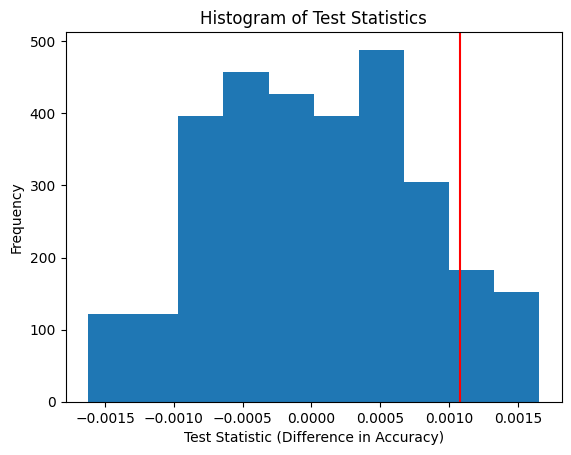

In [120]:
import matplotlib.pyplot as plt

plt.hist(test_stats_arr)
plt.axvline(x=observed_test_stat, color='red')
plt.title('Histogram of Test Statistics')
plt.xlabel('Test Statistic (Difference in Accuracy)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Simulating under the null


In [ ]:
# TODO